In [5]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm
import sklearn

import zipfile
import os

from helper_functions import *

plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

## Read in the Data

In [7]:
full_data = pd.read_csv('cook_county_train.csv')
full_data = log_transform(full_data, 'Sale Price')

## Building a Simple Model & Building Data Pipelines

In [9]:
def process_data_simple(data):
    data = remove_outliers(data, 'Sale Price', lower = 499)
    data = log_transform(data, 'Sale Price')
    data = add_bedrooms(data)
    X = data[['Bedrooms']]
    Y = data['Log Sale Price']
    return X, Y

In [10]:
np.random.seed(1337)
train_simple, valid_simple = train_val_split(full_data)

simple_pipelines = [
    (remove_outliers, None, {
        'variable':'Sale Price',
        'lower':499
    }),
    (log_transform, None, {'col':'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (add_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms', 'Log Building Square Feet'], None)
]

X_train_simple, Y_train_simple = process_data_pipe(train_simple, simple_pipelines, 'Log Sale Price')
X_valid_simple, Y_valid_simple = process_data_pipe(valid_simple, simple_pipelines, 'Log Sale Price')

display(X_train_simple.head())
display(Y_train_simple.head())

,Bedrooms,Log Building Square Feet
130829,4,7.870548
193890,2,7.003065
30507,2,6.852243
91308,2,7.229114
131132,3,7.991254


130829    12.994532
193890    11.848690
30507     11.813037
91308     13.060490
131132    12.516864
Name: Log Sale Price, dtype: float64

In [11]:
linear_model_simple = lm.LinearRegression(fit_intercept = True)
linear_model_simple.fit(X_train_simple, Y_train_simple)
Y_fitted_simple = linear_model_simple.predict(X_train_simple)
Y_predicted_simple = linear_model_simple.predict(X_valid_simple)

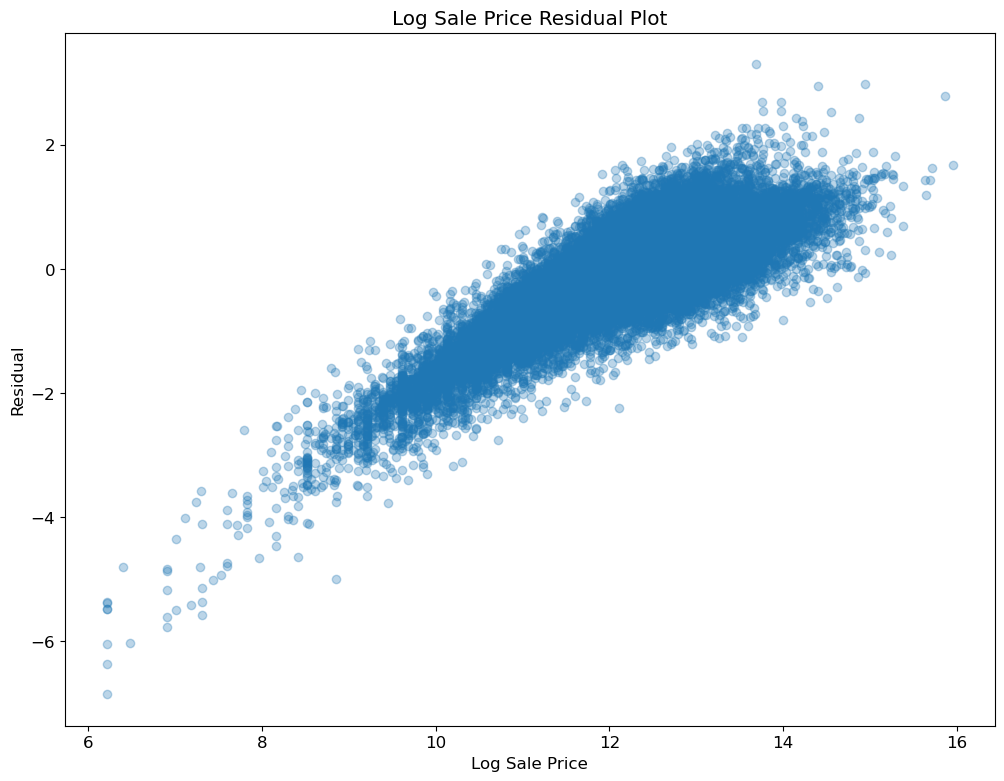

In [12]:
plt.scatter(Y_valid_simple, Y_valid_simple - Y_predicted_simple, alpha = 0.3)
plt.xlabel("Log Sale Price")
plt.ylabel("Residual")
plt.title("Log Sale Price Residual Plot");

## Adding More Features

In [14]:
from helper_functions import *

final_pipelines_train = [
    (remove_outliers, None, {
        'variable':'Sale Price',
        'lower':500
    }),
    (remove_outliers, None, {
        'variable':'Estimate (Building)',
        'lower':2500
    }),
    (remove_outliers, None, {
        'variable':'Estimate (Land)',
        'lower':2500
    }),
    (log_transform, None, {'col':'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (log_transform, None, {'col': 'Land Square Feet'}),
    (log_transform, None, {'col': 'Lot Size'}),
    (log_transform, None, {'col': 'Estimate (Land)'}),
    (log_transform, None, {'col': 'Estimate (Building)'}),
    (add_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Log Building Square Feet', 'Bedrooms',
                      'Log Land Square Feet', 'Log Lot Size', 'Log Estimate (Building)', 'Log Estimate (Land)', 'Age'], None)
]

final_pipelines_test = [
    (log_transform, None, {'col':'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (log_transform, None, {'col': 'Land Square Feet'}),
    (log_transform, None, {'col': 'Lot Size'}),
    (log_transform, None, {'col': 'Estimate (Land)'}),
    (log_transform, None, {'col': 'Estimate (Building)'}),
    (add_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Log Building Square Feet', 'Bedrooms', 
                      'Log Land Square Feet', 'Log Lot Size', 'Log Estimate (Building)', 'Log Estimate (Land)', 'Age'], None)
]
def process_data_final(data, is_test_set=False):
    if not is_test_set:
        copy = data.copy()
        fill_missing = ['Building Square Feet', 'Age', 'Lot Size', 'Estimate (Building)', 'Estimate (Land)']
        for col in fill_missing:
            copy[col] = copy[col].fillna(np.median(copy[col]))
        X, Y = process_data_pipe(copy, final_pipelines_train, 'Log Sale Price')
        return X, Y
    else:
        copy = data.copy()
        fill_missing = ['Building Square Feet', 'Age', 'Lot Size', 'Estimate (Building)', 'Estimate (Land)']
        for col in fill_missing:
            copy[col] = copy[col].fillna(np.median(copy[col]))
        X, Y = process_data_pipe(copy, final_pipelines_test, 'Log Sale Price')
        return X
        
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 295160.69179026276


In [15]:
np.random.seed(1337)
train, validation = train_val_split(full_data)
X,Y = process_data_final(train, is_test_set = False)
a = process_data_final(validation, is_test_set = True)
my_model = sklearn.linear_model.LinearRegression().fit(X, Y)
predicted = my_model.predict(a)
rmse(np.exp(predicted), validation['Sale Price'])

313100.9220333127

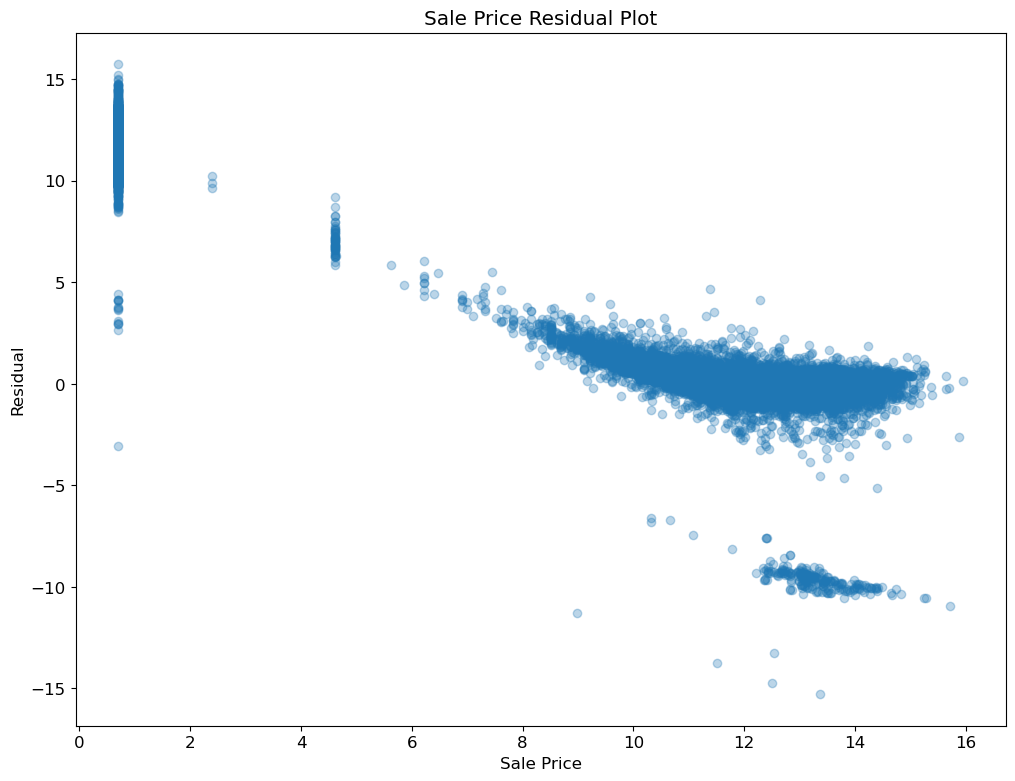

In [16]:
plt.scatter(validation['Log Sale Price'], predicted - validation['Log Sale Price'], alpha = 0.3)
plt.xlabel("Sale Price")
plt.ylabel("Residual")
plt.title("Sale Price Residual Plot");

## Removing Bias

In [18]:
final_pipelines_train = [
    (log_transform, None, {'col':'Sale Price'}),
    (fill_missing, None, {'col':'Building Square Feet'}),
    (fill_missing, None, {'col':'Age'}),
    (fill_missing, None, {'col':'Log Sale Price'}),
    (fill_missing, None, {'col':'Lot Size'}),
    (add_bedrooms, None, None),
    (remove_outliers, None, {
        'variable':'Sale Price',
        'lower':1000,
        'upper':1600000
    }),
    (remove_outliers, None, {
        'variable':'Building Square Feet',
        'lower':500,
        'upper':4000
    }),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (log_transform, None, {'col': 'Land Square Feet'}),
    (log_transform, None, {'col': 'Lot Size'}),
    (select_columns, ['Log Sale Price', 'Log Building Square Feet', 'Bedrooms','Log Lot Size', 'Age'], None)
]

final_pipelines_test = [
    (log_transform, None, {'col':'Sale Price'}),
    (fill_missing, None, {'col':'Building Square Feet'}),
    (fill_missing, None, {'col':'Age'}),
    (fill_missing, None, {'col':'Log Sale Price'}),
    (fill_missing, None, {'col':'Lot Size'}),
    (add_bedrooms, None, None),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (log_transform, None, {'col': 'Land Square Feet'}),
    (log_transform, None, {'col': 'Lot Size'}),
    (select_columns, ['Log Sale Price', 'Log Building Square Feet', 'Bedrooms','Log Lot Size', 'Age'], None)
]

def process_data_final(data, is_test_set=False):
    copy = data.copy()
    if not is_test_set:
        X, Y = process_data_pipe(copy, final_pipelines_train, 'Log Sale Price')
        return X, Y
    else:
        X, Y = process_data_pipe(copy, final_pipelines_test, 'Log Sale Price')
        return X

check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 189417.31537052037


In [19]:
X,Y = process_data_final(train, is_test_set = False)
a = process_data_final(validation, is_test_set = True)
my_model = sklearn.linear_model.LinearRegression().fit(X, Y)
predicted = my_model.predict(a)
rmse(np.exp(predicted), validation['Sale Price'])

261891.06354610738

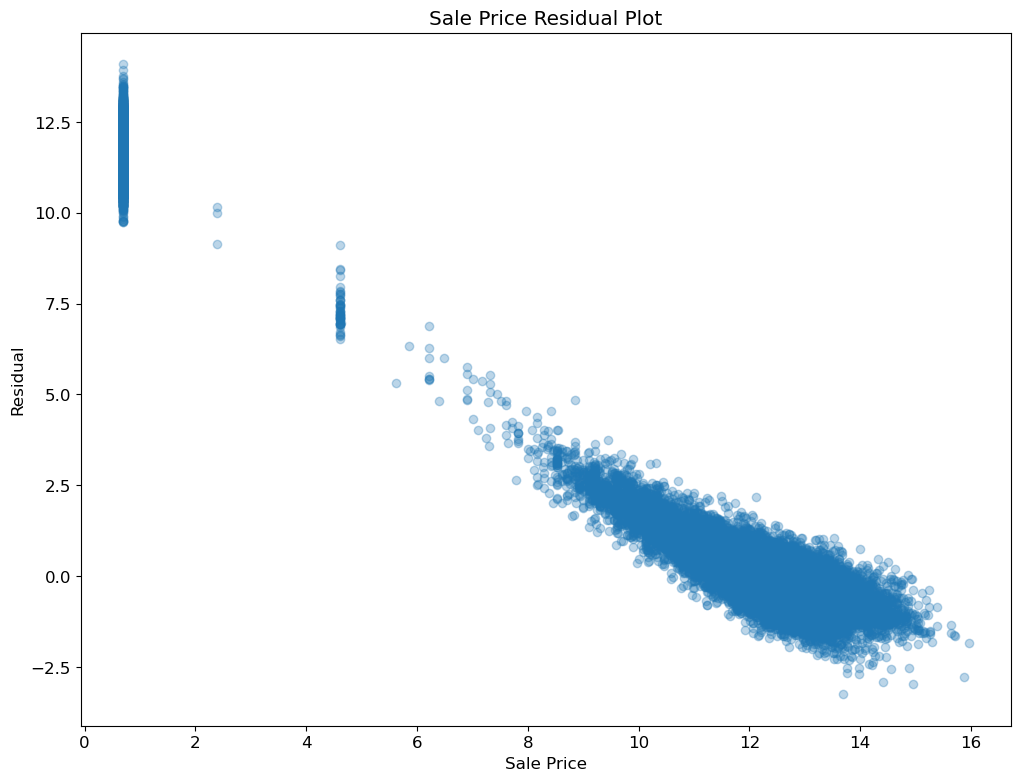

In [20]:
plt.scatter(validation['Log Sale Price'], predicted - validation['Log Sale Price'], alpha = 0.3)
plt.xlabel("Sale Price")
plt.ylabel("Residual")
plt.title("Sale Price Residual Plot");

## Adding More Features

In [22]:
final_pipelines_train = [
    (log_transform, None, {'col':'Sale Price'}),
    (fill_missing, None, {'col':'Building Square Feet'}),
    (fill_missing, None, {'col':'Age'}),
    (fill_missing, None, {'col':'Log Sale Price'}),
    (fill_missing, None, {'col':'Lot Size'}),
    (fill_missing, None, {'col':'Lot Size'}),
    (add_bedrooms, None, None),
    (add_bathrooms, None, None),
    (add_total_rooms, None, None),
    (remove_outliers, None, {
        'variable':'Sale Price',
        'lower':1000,
        'upper':1600000
    }),
    (remove_outliers, None, {
        'variable':'Building Square Feet',
        'lower':500,
        'upper':4000
    }),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (log_transform, None, {'col': 'Land Square Feet'}),
    (log_transform, None, {'col': 'Lot Size'}),
    (select_columns, ['Log Sale Price', 'Log Building Square Feet', 'Bedrooms','Log Lot Size', 'Age', 'Rooms', 'Bathrooms', 'Longitude', 'Latitude', 'Fireplaces'], None)
]

final_pipelines_test = [
    (log_transform, None, {'col':'Sale Price'}),
    (fill_missing, None, {'col':'Building Square Feet'}),
    (fill_missing, None, {'col':'Age'}),
    (fill_missing, None, {'col':'Log Sale Price'}),
    (fill_missing, None, {'col':'Lot Size'}),
    (fill_missing, None, {'col':'Fireplaces'}),
    (add_bedrooms, None, None),
    (add_bathrooms, None, None),
    (add_total_rooms, None, None),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (log_transform, None, {'col': 'Land Square Feet'}),
    (log_transform, None, {'col': 'Lot Size'}),
    (select_columns, ['Log Sale Price', 'Log Building Square Feet', 'Bedrooms','Log Lot Size', 'Age', 'Rooms', 'Bathrooms', 'Longitude', 'Latitude', 'Fireplaces'], None)
]

def process_data_final(data, is_test_set=False):
    copy = data.copy()
    if not is_test_set:
        X, Y = process_data_pipe(copy, final_pipelines_train, 'Log Sale Price')
        return X, Y
    else:
        X, Y = process_data_pipe(copy, final_pipelines_test, 'Log Sale Price')
        return X

check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 172571.8024132388


In [23]:
X,Y = process_data_final(train, is_test_set = False)
X,Y = process_data_final(train, is_test_set = False)
a = process_data_final(validation, is_test_set = True)
my_model = sklearn.linear_model.LinearRegression().fit(X, Y)
predicted = my_model.predict(a)
rmse(np.exp(predicted), validation['Sale Price'])

278145.47323231003

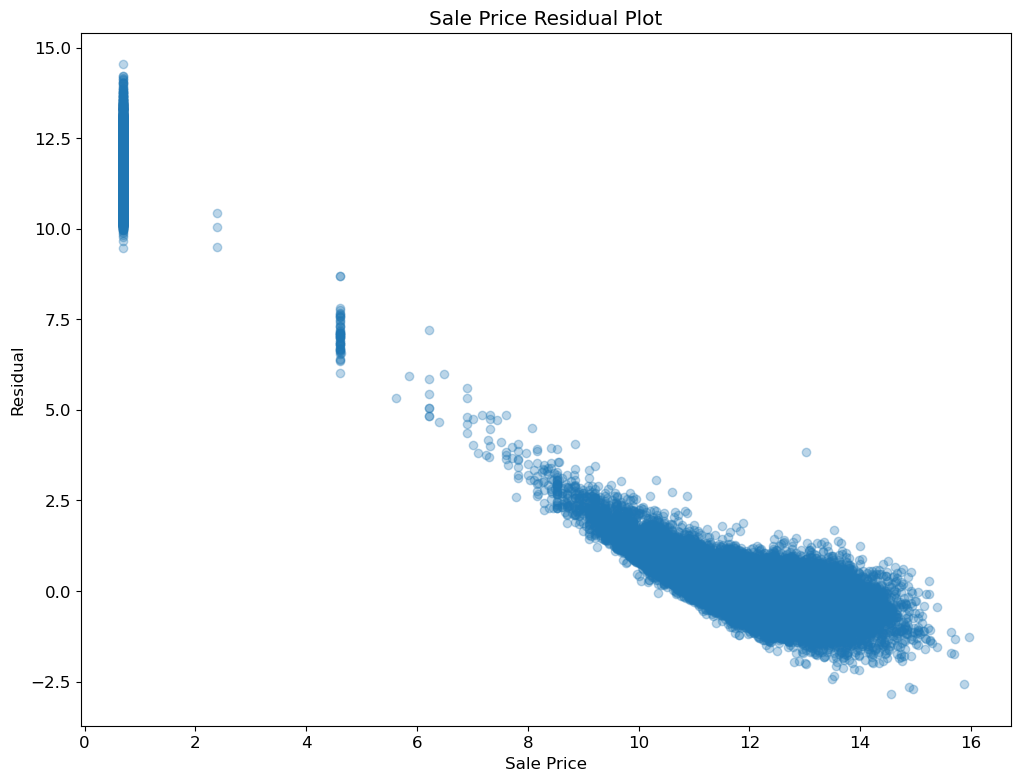

In [24]:
plt.scatter(validation['Log Sale Price'], predicted - validation['Log Sale Price'], alpha = 0.3)
plt.xlabel("Sale Price")
plt.ylabel("Residual")
plt.title("Sale Price Residual Plot");